# Analysis Pipeline - Development Notebook 

In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from scipy.stats import logistic
from sklearn.linear_model import LogisticRegression

## FUNCTIONS 

In [2]:
def performance_curve(t,k,t0):
    x = k*(t - t0); # An extremely simplified version of the function we could use to define resource allocation. Ideally, bounded.
    #x = np.clip(x,0,x.max())
    #Ax = A[0]*x + A[1]
    return logistic.cdf(x) # conversion of resource -> performance
def probe(t,y,n,t0,t_pm, method ='randunif'):
    u = np.random.uniform(size=n) # probe random state values (to be compared with latent performance curve)
    
    # probe time points ** This defines the probing scheme, so we may want to have a function arg define
    if method == 'randunif':
        p = np.random.randint(low=t0-t_pm,high=t0+t_pm,size=n)
    elif method == 'intunif':
        p = np.linspace(start=t0-t_pm,stop=t0+t_pm,num=n)
    elif method == 'centunif':
        p = np.random.randint(low=0-t_pm,high=0+t_pm,size=n)
    
    # We will want to bin/digitize our probe times so we can compute averages w/i time bins
    q = np.empty(shape=(n,))
    i = np.digitize(p,t)
    p = t[i]

    for s in range(n):
        q[s] = np.where(t == p[s])[0][0]
    return y[q.astype(int)] > u, p
def make_json_responses(responses,times,condition = None):
    # Errors
    if condition == None:
        Error('You must choose a condition')
    if len(responses) != len(times):
        Error('Responses and times must be matched in length.')
        
    # Create output
    response_list = []
    for e in range(len(responses)):
        t = times[e]
        corr = responses[e]
        if t >= 0 :
            p = 'd' #only accommodating difficult for now
        else:
            if condition == 'pro':
                p = 'cp'
            elif condition == 're':
                p = 'cr'
        response = {'Event' : 'Response', 'UserID' : None, 'SeqID' : None, 'Piece' : p, 'PercComplete' : None, 't' : t, 'Specific' : {'Correct' : corr}}
        response_list.append(response)
    return response_list
def responses_json2df(list_of_json_events):
    correct = np.empty(shape=(len(list_of_json_events),))
    times = np.empty(shape=(len(list_of_json_events),))
    i = 0
    for e in list_of_json_events:
        correct[i] = e['Specific']['Correct']
        times[i] = e['t']
        i += 1
    df = pd.DataFrame({'correct' : correct, 'times' : times})
    return df

## Generating Data

In [3]:
# This is what our data should look something like, but we will need a lot more of it
gng = {'Event' : 'GNGTaskOn', 'UserID' : 0, 'SeqID' : 0, 'Piece' : 'C1', 'PercComplete' : 10.6, 't' : 12.234, 'Specific' : {'Answer' : 1}}
response = {'Event' : 'Response', 'UserID' : 0, 'SeqID' : 0, 'Piece' : 'PD1', 'PercComplete' : 47, 't' : 12.756, 'Specific' : {'Correct' : 1}}
coll = {'Event' : 'Collision', 'UserID' : 0, 'SeqID' : 0, 'Piece' : 'PD1', 'PercComplete' : 79.1,  't' : 32.111, 'Specific' : {}}
seqon = {'Event' : 'SeqON', 'UserID' : 0, 'SeqID' : 1, 'Piece' : 'B', 'PercComplete' : 0, 't' : 42.000, 
         'Specific' : {'Pieces' : 12, 'Length' : 126, 'Seq' : ['B','C1','PE1','B','C2','PD1','B','C3','PE2','B','C3','PD2']}}

In [4]:
# Define the data-generating process for each event

# General
n = 125 # How many samples we will generate
#seq = ['b','c','e','b','c','d','b','c','e'] # we will use the same chunk sequence for every sample generated
piece_len = 4
#speed = .75
t_pm = 500

# Difficult - Proactive Condition
t = np.linspace(-500,500,1001) # time axis
k = .03 # rate
t0 = -100 # forecast command time
perf_dpro = 1 - performance_curve(t,k,t0)

# Difficult - Reactive Condition
perf_drea = 1 - performance_curve(t,k,0)

# Observations
corr_dpro, t_dpro = probe(t,perf_dpro,n,t0,t_pm, method ='centunif')
corr_drea, t_drea = probe(t,perf_drea,n,0,t_pm, method ='centunif')

In [5]:
len(corr_dpro)

125

In [6]:
# Convert lists of observations into json-like data (this will need to be function)
response_list = []
cond = 'pro'
for e in range(len(corr_dpro)):
    t = t_dpro[e]
    corr = corr_dpro[e]
    if t >= 0 :
        p = 'd'
    else:
        if cond == 'pro':
            p = 'cp'
        elif cond == 're':
            p = 'cr'
    response = {'Event' : 'Response', 'UserID' : None, 'SeqID' : None, 'Piece' : p, 'PercComplete' : None, 't' : t, 'Specific' : {'Correct' : corr}}
    response_list.append(response)

# This & Some more will go into function: make_json_responses()

In [7]:
dpro_json_list = make_json_responses(corr_dpro, t_dpro, condition = 'pro')
drea_json_list = make_json_responses(corr_drea, t_drea, condition = 're')

In [8]:
dpro_json_list[:2]

[{'Event': 'Response',
  'UserID': None,
  'SeqID': None,
  'Piece': 'cp',
  'PercComplete': None,
  't': -382.0,
  'Specific': {'Correct': True}},
 {'Event': 'Response',
  'UserID': None,
  'SeqID': None,
  'Piece': 'cp',
  'PercComplete': None,
  't': -345.0,
  'Specific': {'Correct': True}}]

In [9]:
drea_json_list[:2]

[{'Event': 'Response',
  'UserID': None,
  'SeqID': None,
  'Piece': 'cr',
  'PercComplete': None,
  't': -493.0,
  'Specific': {'Correct': True}},
 {'Event': 'Response',
  'UserID': None,
  'SeqID': None,
  'Piece': 'cr',
  'PercComplete': None,
  't': -246.0,
  'Specific': {'Correct': True}}]

## Reformat Data 

In [10]:
# Convert the data into analysis format -- this will also be a function
correct = np.empty(shape=(len(dpro_json_list),))
times = np.empty(shape=(len(dpro_json_list),))
i=0
for e in dpro_json_list:
    correct[i] = e['Specific']['Correct']
    times[i] = e['t']
    i+=1
    
df = pd.DataFrame({'correct':correct,'times':times})
df.head(5)
# the associated function is responses_json2df()

correct  times
0      1.0 -382.0
1      1.0 -345.0
2      0.0   83.0
3      1.0  -62.0
4      0.0  122.0

## Analysis 

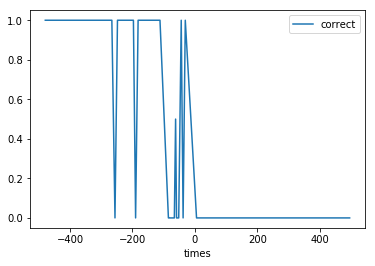

In [11]:
# preliminary plotting of the data
df.groupby(by=df['times']).mean().plot();

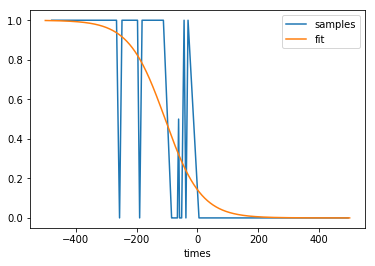

In [12]:
# fit a logistic function
lr = LogisticRegression()
lr.fit(X=df['times'].values.reshape(-1,1),y=df['correct']) # need to reshape X as 2d since fit expects matrix
# We can use this to plot the fit
f = df.groupby(by=df['times']).mean().plot();

t = np.linspace(-500,500,1001) # discrete time axis
fit = lr.predict_proba(t.reshape(-1,1))[:,1] # we want the second column corresponding to P(Correct|Time)

f.plot(t,fit);
f.legend(['samples','fit']);

In [13]:
print('Linear slope: ', lr.coef_, '\nLinear intercept: ', lr.intercept_)

Linear slope:  [[-0.0168913]] 
Linear intercept:  [-1.79596063]


This is in the $\frac{1}{1 + e^{ax + b}}$ form. For interpretability, we will want to convert to $\frac{1}{1 + e^{k(t-t_0)}}$. So, we will just divide the negative of the intercept by the slope to get the mid-point.

In [14]:
print('slope (k): ', lr.coef_, '\nintercept: ', -lr.intercept_/lr.coef_)

slope (k):  [[-0.0168913]] 
intercept:  [[-106.32460048]]


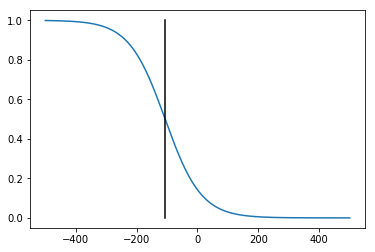

In [15]:
# Plot the intercept
plt.plot(t,fit);
plt.plot([-lr.intercept_[0]/lr.coef_[0],-lr.intercept_[0]/lr.coef_[0]],[0,1],color='k');